In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 1. Daten laden
df = pd.read_csv(
    "/Users/rafaelriesle/Documents/Rafael Riesle/Studium/Semster 7/AWP2/tree_classification/data/preprocessed/valset.csv",
    parse_dates=["time"],
)
df = df.drop(columns=["disturbance_year", "doy"], axis=1)
print(df)

             time     id     b2     b3     b4     b5      b6      b7      b8  \
0      2017-01-30      3  327.0  386.0  314.0  521.0  1092.0  1306.0  1390.0   
1      2017-03-15      3  324.0  417.0  340.0  593.0  1263.0  1534.0  1676.0   
2      2017-03-27      3   87.0  179.0  130.0  497.0   969.0  1239.0  1327.0   
3      2017-05-02      3  125.0  237.0  172.0  401.0  1155.0  1499.0  1624.0   
4      2017-05-09      3  170.0  297.0  197.0  527.0  1366.0  1734.0  1739.0   
...           ...    ...    ...    ...    ...    ...     ...     ...     ...   
198839 2022-10-11  14672  257.0  416.0  275.0  610.0  1638.0  2085.0  2217.0   
198840 2022-10-17  14672  348.0  482.0  342.0  612.0  1626.0  1923.0  2103.0   
198841 2022-10-21  14672  278.0  456.0  326.0  595.0  1645.0  1914.0  2067.0   
198842 2022-10-29  14672  361.0  483.0  298.0  648.0  1585.0  1769.0  2084.0   
198843 2022-11-01  14672  410.0  514.0  323.0  644.0  1556.0  1890.0  1954.0   

           b8a    b11    b12     specie

/Users/rafaelriesle/Documents/Rafael Riesle/Studium/Semster 7/AWP2/tree_classification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rafaelriesle/Documents/Rafael Riesle/Studium/Semster 7/AWP2/tree_classification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rafaelriesle/Documents/Rafael Riesle/Studium/Semster 7/AWP2/tree_classification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision 

                     precision    recall  f1-score   support

      Norway_spruce       0.53      0.51      0.52        76
Norway_spruce_mixed       0.67      0.72      0.69       128
         Scots_pine       0.92      0.92      0.92        91
              beech       0.56      0.74      0.64        19
          disturbed       0.80      0.65      0.72        55
                oak       0.00      0.00      0.00         7
               soil       0.85      0.93      0.89        56

           accuracy                           0.73       432
          macro avg       0.62      0.64      0.63       432
       weighted avg       0.72      0.73      0.73       432

Accuracy: 0.7338
Top 20 Features:
 1. b2_mean_w6                     Importance: 0.02002
 2. b12_mean_w6                    Importance: 0.01515
 3. b6_min_w6                      Importance: 0.01359
 4. b11_max_w5                     Importance: 0.01270
 5. b2_min_w13                     Importance: 0.01217
 6. b5_mean_w5   

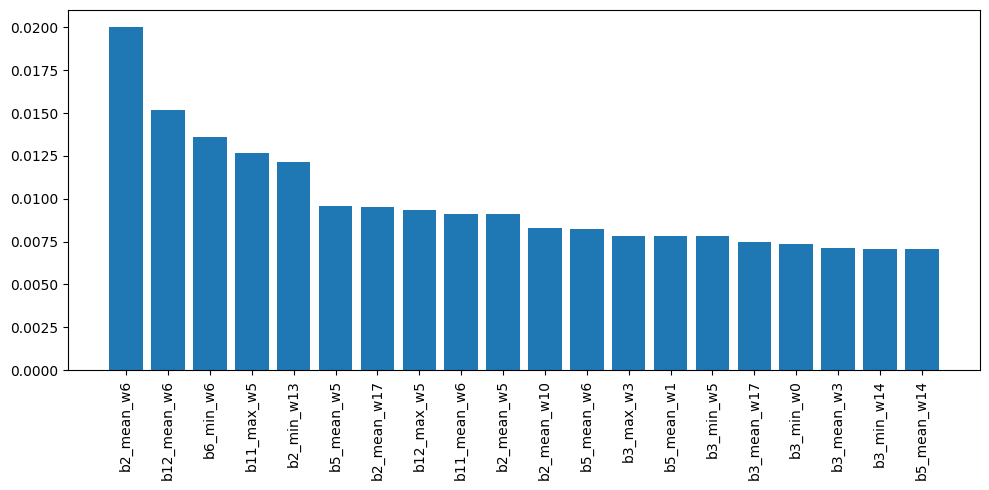

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

def calc_trend(x, y):
    if len(x) < 2: return 0
    xm, ym = np.mean(x), np.mean(y)
    denom = np.sum((x - xm) ** 2)
    return 0 if denom == 0 else np.sum((x - xm) * (y - ym)) / denom

def process_id(id_, group, window=120, step=90):
    group = group.sort_values("time")
    species = group["species"].iloc[0]
    times = group["time_num"].values
    bands = ["b2","b3","b4","b5","b6","b7","b8","b8a","b11","b12"]
    feats=[]
    start=0
    while start < times.max():
        end=start+window
        win=group[(group["time_num"]>=start)&(group["time_num"]<end)]
        if len(win)<2: start+=step; continue
        f={"id":id_,"species":species}
        for b in bands:
            vals=win[b].values; t=win["time_num"].values
            f[f"{b}_mean"]=vals.mean()
            f[f"{b}_std"]=vals.std()
            f[f"{b}_min"]=vals.min()
            f[f"{b}_max"]=vals.max()
            f[f"{b}_trend"]=calc_trend(t,vals)
        feats.append(f)
        start+=step
    return feats

def aggregate_time_series(df, window=120, step=90, n_jobs=-1):
    df=df.copy(); df["time"]=pd.to_datetime(df["time"])
    df["time_num"]=(df["time"]-df["time"].min()).dt.days
    groups=df.groupby("id")
    res=Parallel(n_jobs=n_jobs)(delayed(process_id)(i,g,window,step) for i,g in groups)
    return pd.DataFrame([f for sub in res for f in sub])

def aggregate_to_single_row_keep_windows(df_windows):
    df_windows = df_windows.copy()
    df_windows["window_idx"] = df_windows.groupby("id").cumcount()
    df_pivot = df_windows.pivot_table(index=["id","species"], columns="window_idx")
    df_pivot.columns = [f"{col[0]}_w{col[1]}" if isinstance(col, tuple) else col for col in df_pivot.columns]
    return df_pivot.reset_index()


def train_random_forest(df):
    X=df.drop(columns=["id","species"],errors="ignore")
    y=df["species"]
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)
    clf=RandomForestClassifier(n_estimators=20,random_state=42,n_jobs=-1)
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    print(classification_report(y_test,y_pred))
    print(f"Accuracy: {accuracy_score(y_test,y_pred):.4f}")
    importances=clf.feature_importances_
    names=np.array(X.columns)
    idx=np.argsort(importances)[::-1][:20]
    print("Top 20 Features:")
    for i,n in enumerate(names[idx],1):
        print(f"{i:2d}. {n:30s} Importance: {importances[idx[i-1]]:.5f}")
    plt.figure(figsize=(10,5))
    plt.bar(range(20),importances[idx],align="center")
    plt.xticks(range(20),names[idx],rotation=90)
    plt.tight_layout(); plt.show()
    return clf

# Example usage:
agg_df=aggregate_time_series(df,window=120,step=90,n_jobs=-1)
final_df = aggregate_to_single_row_keep_windows(agg_df)
model=train_random_forest(final_df)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 301003
[LightGBM] [Info] Number of data points in the train set: 1008, number of used features: 1200
[LightGBM] [Info] Start training from score -1.739574
[LightGBM] [Info] Start training from score -1.218630
[LightGBM] [Info] Start training from score -1.563865
[LightGBM] [Info] Start training from score -3.109061
[LightGBM] [Info] Start training from score -2.063693
[LightGBM] [Info] Start training from score -4.082510
[LightGBM] [Info] Start training from score -2.032922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/rafaelriesle/Documents/Rafael Riesle/Studium/Semster 7/AWP2/tree_classification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rafaelriesle/Documents/Rafael Riesle/Studium/Semster 7/AWP2/tree_classification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rafaelriesle/Documents/Rafael Riesle/Studium/Semster 7/AWP2/tree_classification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision 

                     precision    recall  f1-score   support

      Norway_spruce       0.64      0.28      0.39        76
Norway_spruce_mixed       0.48      0.86      0.62       128
         Scots_pine       0.85      0.87      0.86        91
              beech       1.00      0.16      0.27        19
          disturbed       0.92      0.40      0.56        55
                oak       0.00      0.00      0.00         7
               soil       0.96      0.86      0.91        56

           accuracy                           0.66       432
          macro avg       0.69      0.49      0.51       432
       weighted avg       0.72      0.66      0.63       432

Accuracy: 0.6551
Top 20 Features:
 1. b11_max_w0                     Importance: 15
 2. b11_std_w21                    Importance: 4
 3. b4_std_w20                     Importance: 4
 4. b6_min_w7                      Importance: 4
 5. b8_min_w13                     Importance: 4
 6. b11_std_w6                     Importance:

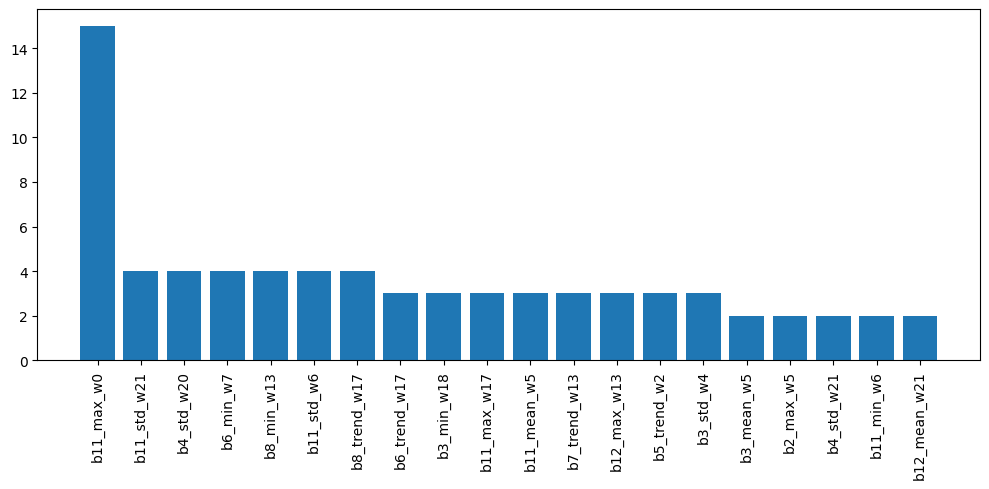

In [3]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

def calc_trend(x, y):
    if len(x) < 2: return 0
    xm, ym = np.mean(x), np.mean(y)
    denom = np.sum((x - xm) ** 2)
    return 0 if denom == 0 else np.sum((x - xm) * (y - ym)) / denom

def process_id(id_, group, window=120, step=90):
    group = group.sort_values("time")
    species = group["species"].iloc[0]
    times = group["time_num"].values
    bands = ["b2","b3","b4","b5","b6","b7","b8","b8a","b11","b12"]
    feats=[]
    start=0
    while start < times.max():
        end=start+window
        win=group[(group["time_num"]>=start)&(group["time_num"]<end)]
        if len(win)<2: start+=step; continue
        f={"id":id_,"species":species}
        for b in bands:
            vals=win[b].values; t=win["time_num"].values
            f[f"{b}_mean"]=vals.mean()
            f[f"{b}_std"]=vals.std()
            f[f"{b}_min"]=vals.min()
            f[f"{b}_max"]=vals.max()
            f[f"{b}_trend"]=calc_trend(t,vals)
        feats.append(f)
        start+=step
    return feats

def aggregate_time_series(df, window=120, step=90, n_jobs=-1):
    df=df.copy(); df["time"]=pd.to_datetime(df["time"])
    df["time_num"]=(df["time"]-df["time"].min()).dt.days
    groups=df.groupby("id")
    res=Parallel(n_jobs=n_jobs)(delayed(process_id)(i,g,window,step) for i,g in groups)
    return pd.DataFrame([f for sub in res for f in sub])

def aggregate_to_single_row_keep_windows(df_windows):
    df_windows = df_windows.copy()
    df_windows["window_idx"] = df_windows.groupby("id").cumcount()
    df_pivot = df_windows.pivot_table(index=["id","species"], columns="window_idx")
    df_pivot.columns = [f"{col[0]}_w{col[1]}" if isinstance(col, tuple) else col for col in df_pivot.columns]
    return df_pivot.reset_index()

def train_lightgbm(df, n_estimators=2, learning_rate=0.1):
    X = df.drop(columns=["id","species"], errors="ignore")
    y = df["species"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    clf = lgb.LGBMClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=42,
        n_jobs=-1
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

    # Feature Importances
    importances = clf.feature_importances_
    names = np.array(X.columns)
    idx = np.argsort(importances)[::-1][:20]

    print("Top 20 Features:")
    for i, n in enumerate(names[idx], 1):
        print(f"{i:2d}. {n:30s} Importance: {importances[idx[i-1]]}")

    # Plot
    plt.figure(figsize=(10,5))
    plt.bar(range(20), importances[idx], align="center")
    plt.xticks(range(20), names[idx], rotation=90)
    plt.tight_layout()
    plt.show()

    return clf

# Beispielaufruf:
agg_df = aggregate_time_series(df, window=120, step=90, n_jobs=-1)
final_df = aggregate_to_single_row_keep_windows(agg_df)
model = train_lightgbm(final_df)


In [4]:
final_df

,id,species,b11_max_w0,b11_max_w1,b11_max_w2,b11_max_w3,b11_max_w4,b11_max_w5,b11_max_w6,b11_max_w7,...,b8a_trend_w14,b8a_trend_w15,b8a_trend_w16,b8a_trend_w17,b8a_trend_w18,b8a_trend_w19,b8a_trend_w20,b8a_trend_w21,b8a_trend_w22,b8a_trend_w23
0,3,soil,899.0,932.0,932.0,1763.5,2926.0,2803.0,2064.0,2384.0,...,-26.631459,3.577644,37.705813,4.959461,-27.048095,-3.973085,21.252164,-0.932326,-24.351710,NaN
1,44,Norway_spruce,569.0,642.0,649.0,686.0,822.0,692.0,450.0,757.0,...,-3.061301,9.750302,5.023521,-3.614455,-2.908186,1.066981,6.182270,-2.019429,NaN,NaN
2,49,Norway_spruce,925.0,699.0,686.0,473.0,536.0,875.0,875.0,497.0,...,5.833397,-4.687361,-7.653846,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,64,Norway_spruce,645.0,834.0,777.0,458.0,668.0,947.0,947.0,639.0,...,-2.475261,-0.822102,0.320904,7.102755,-1.746431,4.669089,-3.256527,7.333991,-2.740189,NaN
4,65,disturbed,902.0,1450.0,977.0,705.0,1198.0,1291.0,1193.0,1083.0,...,-2.088789,-0.910393,-0.467320,2.778880,-2.564039,-0.115075,-2.807277,7.107684,-4.319722,1.906394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,14604,soil,2689.0,2237.0,2260.0,2260.0,2154.0,2214.0,2862.0,2641.0,...,-7.258725,-3.262322,18.288611,4.381928,1.359853,-16.846103,5.756494,0.486792,-5.166344,46.464029
1436,14617,Norway_spruce_mixed,750.0,878.0,827.0,545.0,713.0,995.0,995.0,906.0,...,-3.504265,-3.379983,-1.399677,11.189879,-4.600013,-6.279275,3.425020,6.656538,-6.317254,NaN
1437,14621,Norway_spruce_mixed,704.0,897.0,882.0,553.0,824.0,1018.0,1018.0,638.0,...,-3.381852,-4.445300,-0.698780,9.490545,-5.994452,-3.161183,0.872640,6.816883,-3.659760,-9.314217
1438,14630,Norway_spruce_mixed,542.0,851.0,747.0,714.0,475.0,857.0,759.0,681.0,...,-2.395525,-1.001253,-2.421740,12.767668,-6.073759,0.265449,9.388940,6.419416,-5.932761,7.431312


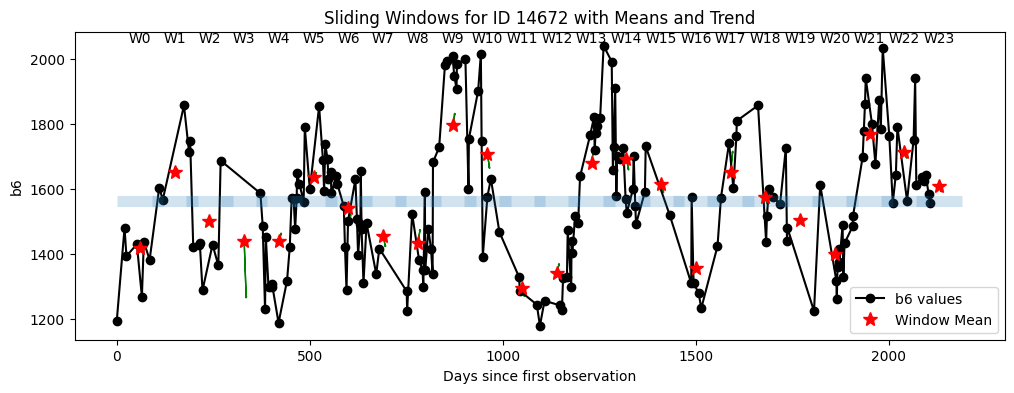

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_sliding_windows_with_features(df, id_, band="b2", window=120, step=90):
    # Filter für die ID
    group = df[df["id"] == id_].sort_values("time")
    times = pd.to_datetime(group["time"])
    times_num = (times - times.min()).dt.days.values
    values = group[band].values

    # Berechne Fenster, Mittelwerte und Trends
    start = 0
    windows = []
    means = []
    trends = []
    while start < times_num.max():
        end = start + window
        mask = (times_num >= start) & (times_num < end)
        win_times = times_num[mask]
        win_vals = values[mask]
        if len(win_vals) >= 2:
            windows.append((start, end))
            means.append(win_vals.mean())
            # Trend berechnen
            xm, ym = np.mean(win_times), np.mean(win_vals)
            denom = np.sum((win_times - xm)**2)
            trend = 0 if denom==0 else np.sum((win_times-xm)*(win_vals-ym))/denom
            trends.append(trend)
        start += step

    # Plot
    plt.figure(figsize=(12,4))
    plt.plot(times_num, values, "ko-", label=f"{band} values")
    for i, (s,e) in enumerate(windows):
        plt.hlines(y=values.mean(), xmin=s, xmax=e, colors='C0', alpha=0.2, linewidth=8)
        plt.text((s+e)/2, max(values), f"W{i}", ha="center", va="bottom")
        plt.plot((s+e)/2, means[i], "r*", markersize=10, label="Window Mean" if i==0 else "")
        plt.arrow((s+e)/2, means[i], 5, trends[i]*10, color='green', head_width=3, head_length=5)

    plt.xlabel("Days since first observation")
    plt.ylabel(band)
    plt.title(f"Sliding Windows for ID {id_} with Means and Trend")
    plt.legend()
    plt.show()

# Beispielaufruf:
plot_sliding_windows_with_features(df, id_=14672, band="b6", window=120, step=90)

/Users/rafaelriesle/Documents/Rafael Riesle/Studium/Semster 7/AWP2/tree_classification/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:05:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                     precision    recall  f1-score   support

      Norway_spruce       0.63      0.58      0.60        76
Norway_spruce_mixed       0.72      0.73      0.73       128
         Scots_pine       0.89      0.97      0.93        91
              beech       0.64      0.74      0.68        19
          disturbed       0.89      0.75      0.81        55
                oak       0.33      0.14      0.20         7
               soil       0.89      0.96      0.92        56

           accuracy                           0.78       432
          macro avg       0.71      0.70      0.70       432
       weighted avg       0.77      0.78      0.77       432

Accuracy: 0.7778
Top 20 Features:
 1. b3_mean_w5                     Importance: 0.08258
 2. b6_max_w21                     Importance: 0.05687
 3. b11_max_w17                    Importance: 0.03728
 4. b5_min_w14                     Importance: 0.02056
 5. b7_max_w21                     Importance: 0.01900
 6. b7_trend_w17 

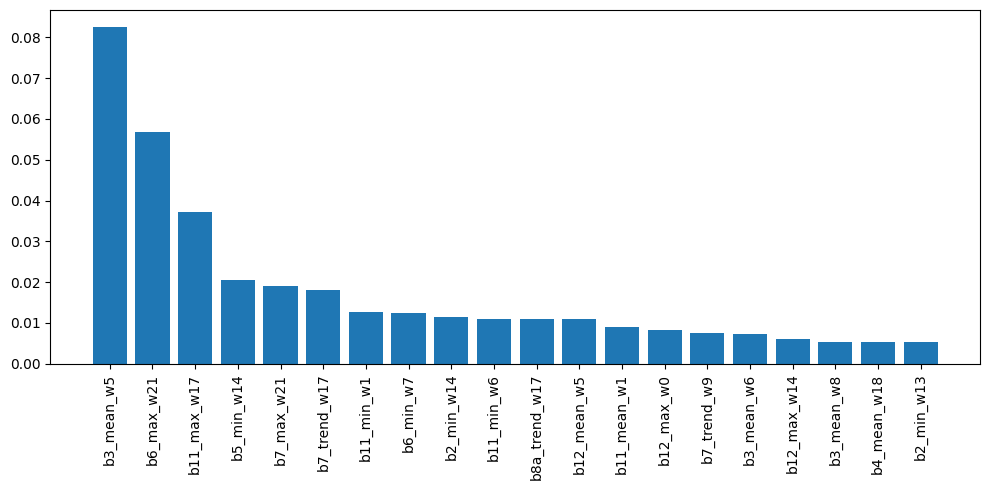

In [12]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# ---------------------------
# Hilfsfunktionen
# ---------------------------

def calc_trend(x, y):
    if len(x) < 2: return 0
    xm, ym = np.mean(x), np.mean(y)
    denom = np.sum((x - xm) ** 2)
    return 0 if denom == 0 else np.sum((x - xm) * (y - ym)) / denom

def process_id(id_, group, window=120, step=90):
    group = group.sort_values("time")
    species = group["species"].iloc[0]
    times = group["time_num"].values
    bands = ["b2","b3","b4","b5","b6","b7","b8","b8a","b11","b12"]
    feats=[]
    start=0
    while start < times.max():
        end=start+window
        win=group[(group["time_num"]>=start)&(group["time_num"]<end)]
        if len(win)<2: start+=step; continue
        f={"id":id_,"species":species}
        for b in bands:
            vals=win[b].values; t=win["time_num"].values
            f[f"{b}_mean"]=vals.mean()
            f[f"{b}_std"]=vals.std()
            f[f"{b}_min"]=vals.min()
            f[f"{b}_max"]=vals.max()
            f[f"{b}_trend"]=calc_trend(t,vals)
        feats.append(f)
        start+=step
    return feats

def aggregate_time_series(df, window=120, step=90, n_jobs=-1):
    df=df.copy()
    df["time"] = pd.to_datetime(df["time"])
    df["time_num"] = (df["time"] - df["time"].min()).dt.days
    groups = df.groupby("id")
    res = Parallel(n_jobs=n_jobs)(delayed(process_id)(i,g,window,step) for i,g in groups)
    return pd.DataFrame([f for sub in res for f in sub])

def aggregate_to_single_row_keep_windows(df_windows):
    df_windows = df_windows.copy()
    df_windows["window_idx"] = df_windows.groupby("id").cumcount()
    df_pivot = df_windows.pivot_table(index=["id","species"], columns="window_idx")
    df_pivot.columns = [f"{col[0]}_w{col[1]}" if isinstance(col, tuple) else col for col in df_pivot.columns]
    return df_pivot.reset_index()

# ---------------------------
# Training mit XGBoost
# ---------------------------
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

def train_xgboost(df, n_estimators=200, learning_rate=0.1, max_depth=6):
    X = df.drop(columns=["id","species"], errors="ignore")
    y = df["species"]

    # ---- Label Encoding ----
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)  # Wandelt Strings in Zahlen um

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
    )

    clf = xgb.XGBClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        objective="multi:softmax",
        eval_metric="mlogloss",
        use_label_encoder=False,
        n_jobs=-1,
        random_state=42
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # ---- Decode Labels zurück zu Strings für Report ----
    y_test_labels = le.inverse_transform(y_test)
    y_pred_labels = le.inverse_transform(y_pred)

    print(classification_report(y_test_labels, y_pred_labels))
    print(f"Accuracy: {accuracy_score(y_test_labels, y_pred_labels):.4f}")

    # Feature Importances
    importances = clf.feature_importances_
    names = np.array(X.columns)
    idx = np.argsort(importances)[::-1][:20]

    print("Top 20 Features:")
    for i, n in enumerate(names[idx], 1):
        print(f"{i:2d}. {n:30s} Importance: {importances[idx[i-1]]:.5f}")

    # Plot
    plt.figure(figsize=(10,5))
    plt.bar(range(20), importances[idx], align="center")
    plt.xticks(range(20), names[idx], rotation=90)
    plt.tight_layout()
    plt.show()

    return clf, le 


# ---------------------------
# Beispielaufruf
# ---------------------------

agg_df = aggregate_time_series(df, window=120, step=90, n_jobs=-1)
final_df = aggregate_to_single_row_keep_windows(agg_df)
model = train_xgboost(final_df)
